# SEC Filings

The data is provided in zipped text files. Unzip the file and place the 'SEC-filings' directory into the './data' directory. 

A related dataset in similar format is the conll2003 dataset, available from [HuggingFace](https://huggingface.co/datasets/conll2003). This could be used as a source of additional training data, but note it contains a different kind of text (different 'domain'). 

In [1]:
# Data Extraction
import re
import numpy as np
import warnings
import params as p

from sklearn.model_selection import train_test_split

# Other
import matplotlib.pyplot as plt
import nltk
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_classification_report, flat_f1_score
from sklearn.metrics import make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter

import optuna

## Settings

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

## Import Data

In [3]:
def read_sec_filings(split):
    # Use this function to load the SEC filings data from text files
    
    if split == 'train':
        with open('./data/SEC-filings/train/FIN5.txt') as fp:
            lines = fp.readlines()
    else:
        with open('./data/SEC-filings/test/FIN3.txt') as fp:
            lines = fp.readlines()
   
    # store the tokens and labels for all sentences
    sentences = []
    labels = []

    # the tokens and labels for the current sentence
    current_sen = []
    current_labels = []

    for i in range(2, len(lines)):
        # print(f'This is line {i}')
        # print(lines[i])

        if len(lines[i]) > 1:  # Line with some data on: The data consists of tokens and tags.
            data = re.split(' ', lines[i])  # tokenise the line
            # print(data)
            current_sen.append(data[0])  # append the token 
            
            # data[1] contains POS tags -- you can also use these in your model.
            
            current_labels.append(data[3].strip())  # append the NER tag
        elif len(current_sen) > 1:  # this marks the end of a sentence
            # end of sentence
            sentences.append(current_sen)  # save the tokens for this sentence
            current_sen = []  # reset

            labels.append(current_labels)  # save the tags for this sentence
            current_labels = []

    if len(current_sen) > 1:  # save the last sentence
        sentences.append(current_sen)
        labels.append(current_labels)
    
    print(f'Number of sentences loaded = {len(sentences)}')
    print(f'Number of unique labels: {np.unique(np.concatenate(labels))}')
    
    return sentences, labels

In [4]:
print('Loading the original training set: ')
sentences_ner, labels_ner = read_sec_filings('train')

print('\nLoading the test set: ')
test_sentences_ner, test_labels_ner = read_sec_filings('test')

Loading the original training set: 
Number of sentences loaded = 1152
Number of unique labels: ['I-LOC' 'I-MISC' 'I-ORG' 'I-PER' 'O']

Loading the test set: 
Number of sentences loaded = 303
Number of unique labels: ['I-LOC' 'I-MISC' 'I-ORG' 'I-PER' 'O']


As before, we could create a validation split from the training set:

In [5]:
train_sentences_ner, val_sentences_ner, train_labels_ner, val_labels_ner = train_test_split(
    sentences_ner, 
    labels_ner, 
    test_size=0.2,
    random_state=73
    # stratify=labels_ner  # there are too few examples of some classes to stratify
)

print(f'Number of training sentences = {len(train_sentences_ner)}')
print(f'Number of validation sentences = {len(val_sentences_ner)}')

Number of training sentences = 921
Number of validation sentences = 231


# Task 2 Answer

### Clean Data

In [6]:
def crf_word_preprocessing(word, ref):

    word_features = {
        'bias' : 1.0,
        f'word_{ref}_lower' : word.lower(),
        f'word_{ref}_end3' : word[-3:],
        f'word_{ref}_end2' : word[-2:],
        f'word_{ref}_beg' : word[:3],
        f'word_{ref}_isupper' : word.isupper(),
        f'word_{ref}_istitle' : word.istitle(),
        f'word_{ref}_isdigit' : word.isdigit(),
        f'word_{ref}_postag' : nltk.pos_tag([word])[0][1]
        }

    return word_features

In [7]:
def crf_sentence_preprocessing(sentence):

    sentence_features = []

    for idx in range(len(sentence)):

        word = sentence[idx]

        word_features = crf_word_preprocessing(word, 0)

        if idx > 0:
            word_features = {
                **word_features,
                **crf_word_preprocessing(sentence[idx - 1], -1)
                }
        else:
            word_features['BOS'] = True

        if idx < len(sentence) - 1:
            word_features = {
                **word_features,
                **crf_word_preprocessing(sentence[idx + 1], +1)
            }
        else:
            word_features['EOS'] = True

        sentence_features.append(word_features)

    return sentence_features

In [8]:
def crf_data_preprocessing(data):
    opt = [crf_sentence_preprocessing(sentence) for sentence in data]
    print('data:', len(data), 'out:', len(opt))
    return opt

### Preprocess Train Data

In [9]:
X_train = crf_data_preprocessing(train_sentences_ner)
X_test = crf_data_preprocessing(test_sentences_ner)
X_val = crf_data_preprocessing(val_sentences_ner)

data: 921 out: 921
data: 303 out: 303
data: 231 out: 231


### NER Modelling

In [10]:
tagger = CRF()
tagger.fit(
    X = X_train,
    y = train_labels_ner,
)

CRF(keep_tempfiles=None)

In [11]:
y_pred = tagger.predict(X_test)

In [12]:
labels = list(tagger.classes_)
labels.remove('O')
labels

['I-PER', 'I-ORG', 'I-LOC', 'I-MISC']

In [13]:
print('F1 Score (train):', flat_f1_score(train_labels_ner, tagger.predict(X_train), average='weighted', labels=labels))
print('F1 Score (test):', flat_f1_score(test_labels_ner, tagger.predict(X_test), average='weighted', labels=labels))

F1 Score (train): 0.9743416791115298
F1 Score (test): 0.672484905956292


In [14]:
sorted_labels = sorted(labels, key=lambda name: (name[1:], name[0]))
print(flat_classification_report(y_pred= tagger.predict(X_test), y_true = test_labels_ner, labels=sorted_labels, digits=4))

              precision    recall  f1-score   support

       I-LOC     0.8095    0.4304    0.5620        79
      I-MISC     0.0000    0.0000    0.0000         7
       I-ORG     0.7500    0.2105    0.3288       114
       I-PER     0.9657    0.8347    0.8955       236

   micro avg     0.9173    0.5849    0.7143       436
   macro avg     0.6313    0.3689    0.4466       436
weighted avg     0.8655    0.5849    0.6725       436



/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Tuning

In [15]:
sampler = optuna.samplers.TPESampler(seed=p.RANDOM_STATE)
study = optuna.create_study(sampler = sampler, direction = 'maximize', study_name = 'NER_HyperParam_CV')

oscv_params = {
    'c1' : optuna.distributions.LogUniformDistribution(1e-4, 1e4),
    'c2' : optuna.distributions.LogUniformDistribution(1e-4, 1e4)
}

# use the same metric for evaluation
f1_scorer = make_scorer(
    score_func = flat_f1_score,
    average = 'weighted',
    labels = labels
    )

oscv = optuna.integration.OptunaSearchCV(
    study = study,
    estimator = CRF(),
    param_distributions = oscv_params,
    cv = 5,
    n_jobs = -1,
    n_trials = 200,
    random_state = p.RANDOM_STATE,
    refit = True,
    scoring = f1_scorer,
    verbose = 1
)

oscv.fit(X_train, train_labels_ner)

[I 2022-04-10 19:28:44,149] A new study created in memory with name: NER_yperParam_CV
/var/folders/2f/cwgmhyzx4fn5cwp5j_dpmsd00000gn/T/ipykernel_73762/756603221.py:16: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  oscv = optuna.integration.OptunaSearchCV(
[I 2022-04-10 19:28:44,162] Searching the best hyperparameters using 921 samples...
/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
[I 2022-04-10 19:29:45,594] Trial 5 finished with value: 0.0 and parameters: {'c1': 1160.0193702418346, 'c2': 0.0005989451796748623}. Best is trial 5 with value: 0.0.
[I 2022-04-10 19:29:47,072] Trial 6 finished with value: 0.053681954377600614 and parameters: {'c1': 0.00016665818294447796, 'c2': 4

OptunaSearchCV(estimator=CRF(keep_tempfiles=None), n_jobs=-1, n_trials=200,
               param_distributions={'c1': LogUniformDistribution(high=10000.0, low=0.0001),
                                    'c2': LogUniformDistribution(high=10000.0, low=0.0001)},
               random_state=73,
               scoring=make_scorer(flat_f1_score, average=weighted, labels=['I-PER', 'I-ORG', 'I-LOC', 'I-MISC']),
               study=<optuna.study.study.Study object at 0x176aee8e0>,
               verbose=1)

In [84]:
tune_tagger = CRF()

rs_params = {
    'c1': np.logspace(-4, 4, 25),
    'c2': np.logspace(-4, 4, 25),
}

# use the same metric for evaluation
f1_scorer = make_scorer(
    score_func = flat_f1_score,
    average = 'weighted',
    labels = labels
    )

# search
rs = RandomizedSearchCV(
    estimator = tune_tagger,
    param_distributions = rs_params,
    cv = 10,
    verbose = 1,
    n_jobs = -1,
    n_iter = 50,
    scoring = f1_scorer
    )

rs.fit(X_train, train_labels_ner)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_pa

RandomizedSearchCV(cv=3, estimator=CRF(keep_tempfiles=None), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'c1': array([1.00000000e-04, 2.15443469e-04, 4.64158883e-04, 1.00000000e-03,
       2.15443469e-03, 4.64158883e-03, 1.00000000e-02, 2.15443469e-02,
       4.64158883e-02, 1.00000000e-01, 2.15443469e-01, 4.64158883e-01,
       1.00000000e+00, 2.15443469e+00, 4.64158883e+00, 1.00000000e+0...
       4.64158883e-02, 1.00000000e-01, 2.15443469e-01, 4.64158883e-01,
       1.00000000e+00, 2.15443469e+00, 4.64158883e+00, 1.00000000e+01,
       2.15443469e+01, 4.64158883e+01, 1.00000000e+02, 2.15443469e+02,
       4.64158883e+02, 1.00000000e+03, 2.15443469e+03, 4.64158883e+03,
       1.00000000e+04])},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['I-PER', 'I-ORG', 'I-LOC', 'I-MISC']),
                   verbose=1)

In [123]:
print('Best Parameters:', rs.best_params_)
print('Best CV Score:', rs.best_score_)

Best Parameters: {'c2': 0.00046415888336127773, 'c1': 0.004641588833612777}
Best CV Score: 0.8557275746264251


In [18]:
tuned_crf = oscv.best_estimator_

In [19]:
print('F1 Score (train):', flat_f1_score(train_labels_ner, tuned_crf.predict(X_train), average='weighted', labels=labels))
print('F1 Score (test):', flat_f1_score(test_labels_ner, tuned_crf.predict(X_test), average='weighted', labels=labels))

F1 Score (train): 0.9972453099683342
F1 Score (test): 0.6839502657885984


### Displaying Results

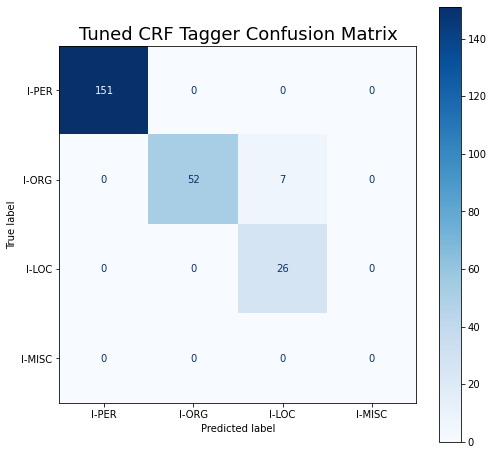

In [126]:
def create_confusion_matrix(y_true, y_pred, ner_labels):

    fig, ax = plt.subplots(1, 1, figsize = (8, 8))

    true = [label for sent_list in y_true for label in sent_list]
    pred = [label for sent_list in y_pred for label in sent_list]

    cm = confusion_matrix(true, pred, ner_labels)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ner_labels)
    disp.plot(cmap = 'Blues', ax = ax)

    plt.title('Tuned CRF Tagger Confusion Matrix', fontdict={'fontsize' : 18})

    plt.show()

create_confusion_matrix(
    y_pred=tuned_crf.predict(X_val),
    y_true=val_labels_ner,
    ner_labels = labels
)

### Feature Importance

In [130]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(tuned_crf.state_features_).most_common(10))

print("\nTop negative:")
print_state_features(Counter(tuned_crf.state_features_).most_common()[-10:])

Top positive:
13.091088 I-ORG    word_0_lower:bank
12.299236 I-PER    word_0_lower:borrower
11.672579 I-PER    word_0_lower:lender
9.572515 I-ORG    word_0_beg:Biz
8.576968 O        bias
8.524362 I-ORG    word_0_lower:vringo
7.845858 I-LOC    word_0_lower:commonwealth
6.755236 I-LOC    word_0_lower:massachusetts
6.593633 I-LOC    word_0_lower:northwest
6.074537 I-LOC    word_0_lower:east

Top negative:
-2.894897 O        word_0_beg:Air
-3.380172 O        word_0_end3:wer
-3.441826 I-LOC    word_1_end2:),
-3.537018 O        word_0_end2:an
-3.589350 O        word_0_end2:na
-3.611924 O        word_1_lower:corporation
-3.729980 O        word_0_beg:nor
-4.439450 O        word_0_istitle
-4.585986 O        word_0_beg:sou
-4.810937 O        word_0_postag:NNP
